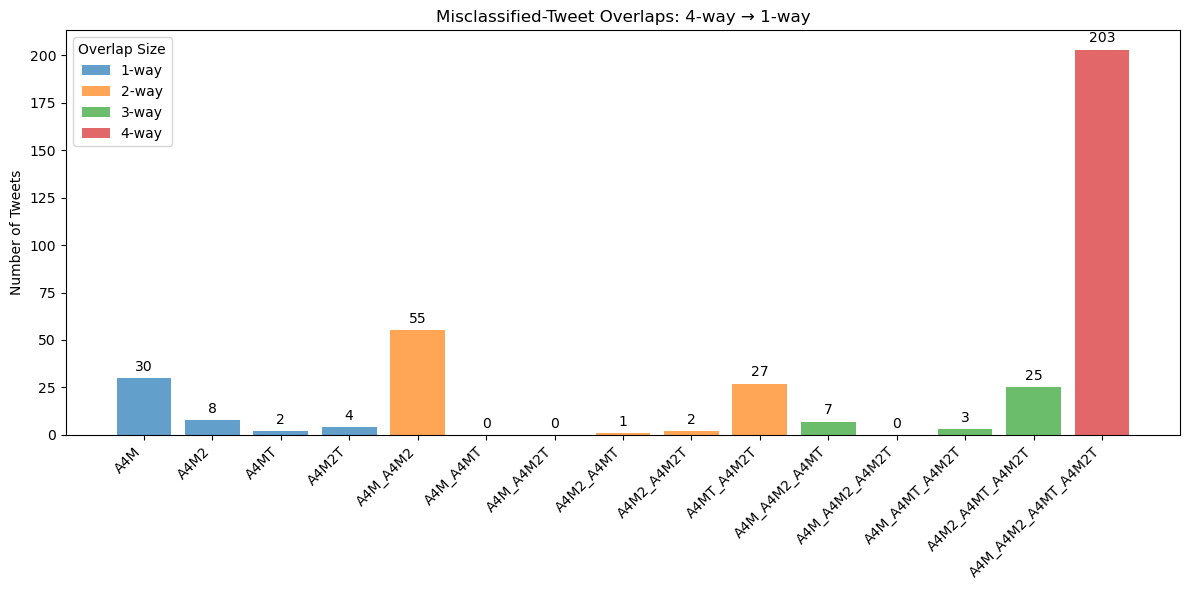

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Configure file locations
data_dir = Path(".")
files = {
    "A4M":       data_dir / "AzureAI_4o-mini/AzureAI_4o-mini_misclassified_tweets.csv",
    "A4M2":      data_dir / "AzureAI_4o-mini-2/AzureAI_4o-mini-2_misclassified_tweets.csv",
    "A4MT":      data_dir / "Azure_AI_4o-mini-withTraining/Azure_AI_4o-mini-withTraining_misclassified_tweets.csv",
    "A4M2T":     data_dir / "AzureAI_4o-mini-2-withTraining/AzureAI_4o-mini-2-withTraining_misclassified_tweets.csv"
}

# 2. Load & normalize each CSV, keep full metadata
dfs = {}
for model, path in files.items():
    df = pd.read_csv(path)
    df = df.rename(columns={
        'Original full Tweet': 'text',
        'True label':           'true_label',
        'Predicted label':      'predicted_label',
        'Confidence level':     'confidence',
        'Reasoning':            'model_reasoning',
        'Conversation history': 'history'
    })
    df['model'] = model
    dfs[model] = df[['text','true_label','predicted_label','confidence',
                     'model_reasoning','history','model']].drop_duplicates()

# 3. Concatenate full metadata
all_meta = pd.concat(dfs.values(), ignore_index=True)

# 4. Build sets of texts per model for overlap calculations
text_sets = {model: set(df['text']) for model, df in dfs.items()}

# Prepare to record counts for plotting
overlap_info = []

# Helper to annotate and save a DataFrame of texts
def annotate_and_save(texts, combo_name):
    subset = all_meta[all_meta['text'].isin(texts)].copy()
    # aggregate per‐tweet across models
    annotated = subset.groupby('text').agg({
        'true_label':       'first',
        'predicted_label':  'first',
        'confidence':       lambda x: list(x),
        'model_reasoning':  lambda x: list(x),
        'history':          lambda x: list(x),
        'model':            lambda x: list(x)
    }).reset_index().rename(columns={'model':'models'})
    annotated.to_csv(data_dir / f"common_{combo_name}.csv", index=False)
    return len(annotated)

# 5. Common to all 4
combo4 = tuple(files.keys())
common4 = set.intersection(*(text_sets[m] for m in combo4))
count4 = annotate_and_save(common4, "_".join(combo4))
overlap_info.append(("4-way", "_".join(combo4), count4))

# 6. Common to exactly 3
for combo in combinations(files.keys(), 3):
    inter3 = set.intersection(*(text_sets[m] for m in combo))
    # exclude any that appear in the fourth model
    fourth = [m for m in files if m not in combo][0]
    exact3 = inter3 - text_sets[fourth]
    combo_name = "_".join(combo)
    count3 = annotate_and_save(exact3, combo_name)
    overlap_info.append(("3-way", combo_name, count3))

# 7. Common to exactly 2
for combo in combinations(files.keys(), 2):
    inter2 = text_sets[combo[0]] & text_sets[combo[1]]
    # exclude any that appear in the other two
    others = set().union(*(text_sets[m] for m in files if m not in combo))
    exact2 = inter2 - others
    combo_name = "_".join(combo)
    count2 = annotate_and_save(exact2, combo_name)
    overlap_info.append(("2-way", combo_name, count2))

# 8. Unique to exactly 1 (singles)
for model in files:
    unique = text_sets[model] - set().union(*(text_sets[m] for m in files if m != model))
    combo_name = model
    count1 = annotate_and_save(unique, combo_name)
    overlap_info.append(("1-way", combo_name, count1))

# 9. Plot bar chart of counts with annotations
plot_df = pd.DataFrame(overlap_info, columns=["type","combo","count"])
plt.figure(figsize=(12,6))

all_bars = []
for t, grp in plot_df.groupby("type"):
    bars = plt.bar(grp["combo"], grp["count"], label=t, alpha=0.7)
    all_bars.extend(bars)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Tweets")
plt.title("Misclassified-Tweet Overlaps: 4-way → 1-way")
plt.legend(title="Overlap Size")

# Add annotation on top of each bar
for bar in all_bars:
    height = bar.get_height()
    plt.annotate(
        f"{int(height)}",                    # label text
        xy=(bar.get_x() + bar.get_width()/2, height),   # position at top-center of bar
        xytext=(0, 3),                        # 3 points vertical offset
        textcoords="offset points",
        ha="center", va="bottom"
    )

plt.tight_layout()
plt.savefig("misclassified_overlaps_annotated.pdf")
plt.show()
